## Imports

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string     
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy
import pyLDAvis.sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

stop_words = stopwords.words('english')
sp = spacy.load('en_core_web_sm')
lemmatizer = WordNetLemmatizer()

## Data Preprocessing

In [166]:
# read all datasets
df_appceleratorstudio = pd.read_csv('./data/appceleratorstudio.csv')
df_aptanastudio = pd.read_csv('./data/aptanastudio.csv')
df_bamboo = pd.read_csv('./data/bamboo.csv')
df_clover = pd.read_csv('./data/clover.csv')
df_datamanagement = pd.read_csv('./data/datamanagement.csv')
df_duracloud = pd.read_csv('./data/duracloud.csv')
df_jirasoftware = pd.read_csv('./data/jirasoftware.csv')
df_mesos = pd.read_csv('./data/mesos.csv')
df_moodle = pd.read_csv('./data/moodle.csv')
df_mule = pd.read_csv('./data/mule.csv')
df_mulestudio = pd.read_csv('./data/mulestudio.csv')
df_springxd = pd.read_csv('./data/springxd.csv')
df_talenddataquality = pd.read_csv('./data/talenddataquality.csv')
df_talendesb = pd.read_csv('./data/talendesb.csv')
df_titanium = pd.read_csv('./data/titanium.csv')
df_usergrid = pd.read_csv('./data/usergrid.csv')

In [167]:
dataset_arr = [df_appceleratorstudio,
        df_aptanastudio,
        df_bamboo,
        df_clover,
        df_datamanagement,
        df_duracloud,
        df_jirasoftware,
        df_mesos,
        df_moodle,
        df_mule,
        df_mulestudio,
        df_springxd,
        df_talenddataquality,
        df_talendesb,
        df_titanium,
        df_usergrid]

In [168]:
def make_dataset(datasets_pd_array):
    # union all datasets
    df_all = pd.concat(datasets_pd_array, ignore_index=True)
    
    # new dataframe with valid datapoints
    df_all = df_all.loc[df_all['storypoint'].isin([1, 2, 3, 5, 8, 13, 20, 40, 100])]
    
    # seperate data from labels
    X = df_all.drop(["issuekey", "storypoint"], axis=1)
    y = df_all["storypoint"].values
    
    # replace missing values with empty strings
    X = X.fillna('')
    
    # concat title with description
    X["title_description"] = X["title"] + " " +  X["description"]
    
    # get numpy array
    text = X["title_description"].to_numpy()
    
    return text, y

In [169]:
def create_corpus(text_arr):
    corpus = []

    for doc in text_arr:
        #lowercase
        doc = doc.lower() 
        #remove "{html}" strings
        doc = doc.replace('\{html\}', '')
        #remove html tags
        doc = BeautifulSoup(doc, 'html.parser').get_text()
        #remove all paths/urls/--keys
        pattern = re.compile(r'[/\-+\\+]')
        doc_split = [token for token in WhitespaceTokenizer().tokenize(doc) if not pattern.findall(token)]
        doc = " ".join(doc_split)

        #tokenize and remove stop words and punctuation symbols and spaces using spaCy
        #use lemmas
        doc_spacy = sp(doc)
        doc_tokenized_spacy = [token.lemma_ for token in doc_spacy
            if not token.is_stop and not token.is_punct and not token.is_space]
        
        #reprocessing additionaly with nltk give much better results
        doc_nltk = " ".join(doc_tokenized_spacy)
        #tokenize and remove stop words and punctuation symbols using nltk 
        doc_tokenized_spacy_nltk = [token for token in nltk.word_tokenize(doc_nltk)
            if token.isalpha()]
                                                        
        corpus.append(doc_tokenized_spacy_nltk)
    return corpus    

In [170]:
#get union of datasets
text, labels = make_dataset(dataset_arr)

#create corpus
corpus = create_corpus(text)
len(corpus)

20761

In [171]:
vocab = set(token for doc in corpus for token in doc)
len(vocab)

22462

In [172]:
def show_most_freq_n(corp, n):
    allwords = [token for doc in corp for token in doc]
    
    # word freqs    
    mostcommon_small = nltk.FreqDist(allwords).most_common(n)
    print(mostcommon_small)
    x, y = zip(*mostcommon_small)
    plt.figure(figsize=(50,30))
    plt.margins(0.02)
    plt.bar(x, y)
    plt.xlabel('Words', fontsize=50)
    plt.ylabel('Frequency of Words', fontsize=50)
    plt.yticks(fontsize=40)
    plt.xticks(rotation=60, fontsize=40)
    plt.title('Frequency of {} Most Common Words'.format(n), fontsize=60)
    plt.show()    

[('code', 9877), ('error', 8391), ('file', 6569), ('create', 6527), ('add', 5688), ('test', 5017), ('project', 4985), ('studio', 4860), ('new', 4833), ('run', 4819), ('build', 4713), ('user', 4403), ('result', 4334), ('use', 4320), ('need', 4235), ('module', 4124), ('update', 3885), ('step', 3542), ('fail', 3443), ('version', 3438), ('app', 3295), ('message', 3247), ('set', 3191), ('work', 3184), ('info', 3183), ('support', 3157), ('change', 3142), ('android', 3013), ('log', 2864), ('issue', 2665), ('titanium', 2664), ('window', 2641), ('default', 2611), ('sdk', 2543), ('like', 2423), ('var', 2405), ('start', 2385), ('property', 2382), ('type', 2300), ('method', 2234), ('value', 2226), ('expect', 2223), ('open', 2219), ('job', 2212), ('select', 2188), ('function', 2156), ('line', 2143), ('master', 2076), ('source', 2068), ('remove', 2042)]


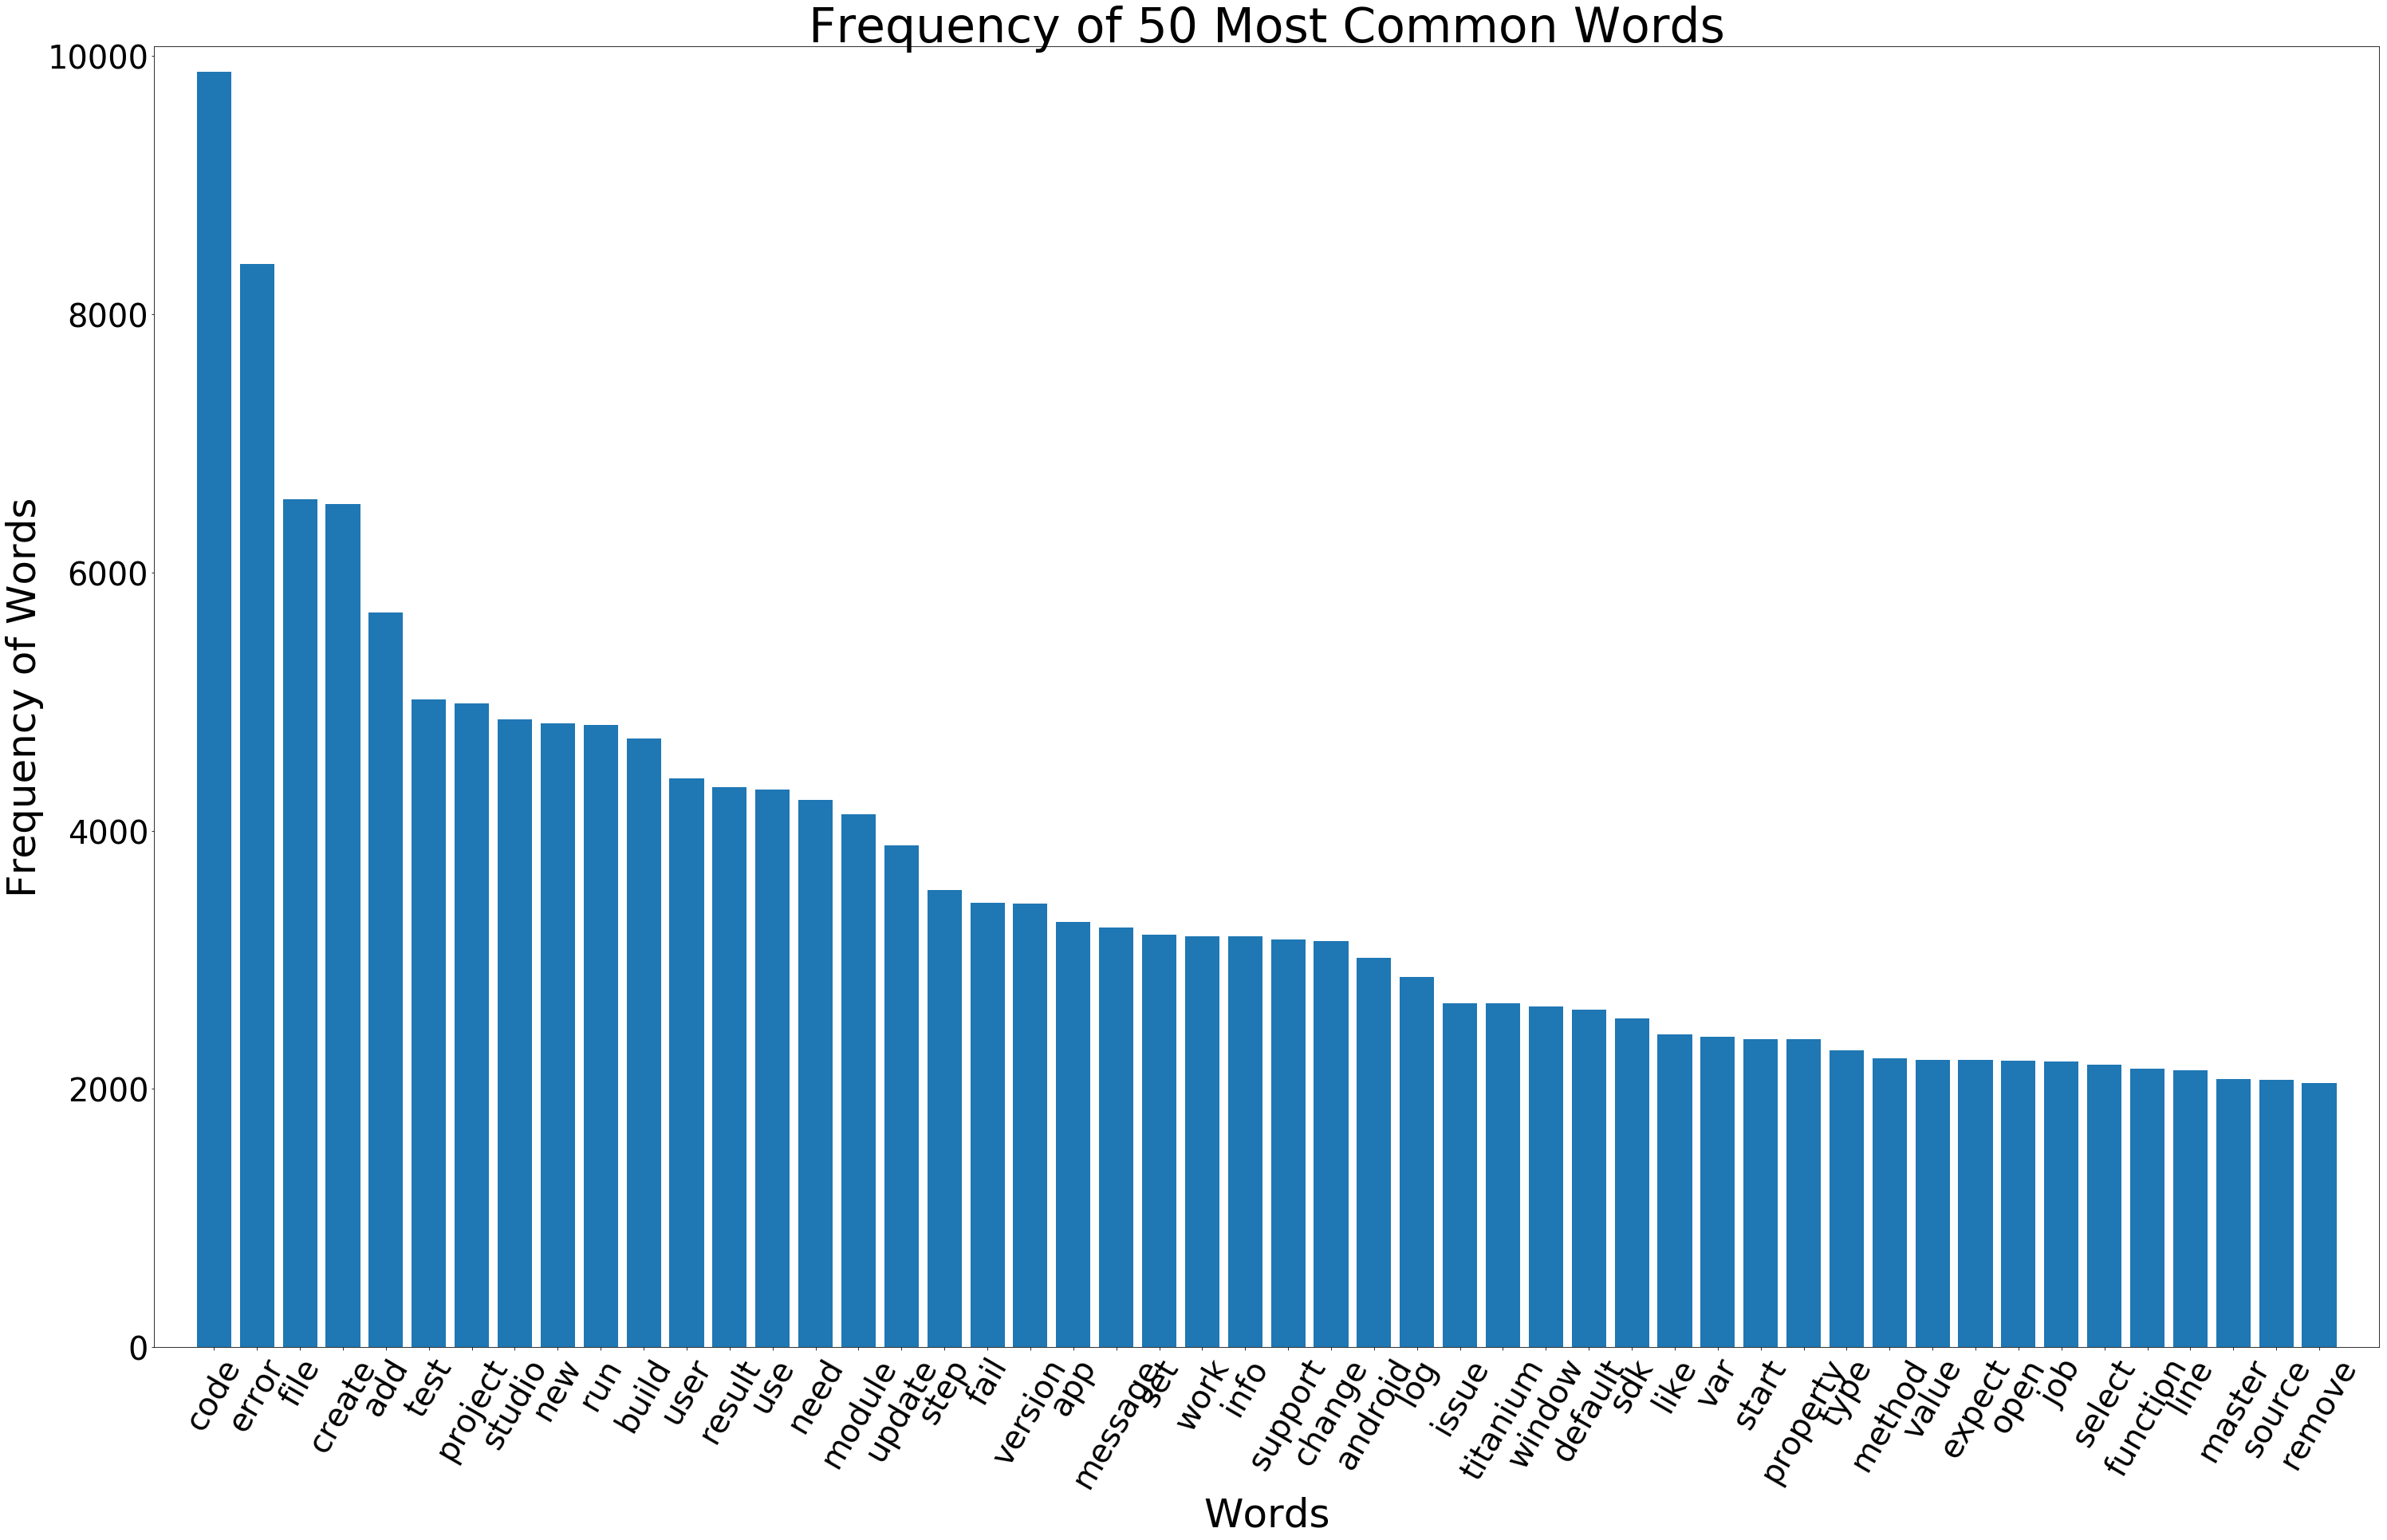

In [173]:
show_most_freq_n(corpus, 50)

## Topic Modeling

### CountVectorizer

The result is called a document token(word) matrix. 

Max_df=0.9 will remove words that appear in more than 90% of the docs. 

Min_df=25 will remove words that appear in less than 25 docs.

In [174]:
# create text of arrays from corpus
text = [" ".join(doc_arr) for doc_arr in corpus]

In [175]:
text[0]

'add object literal function invocation html the idea metadata capture type function arg able create instance type object literal arg function invocation example html'

In [176]:
vectorizer = CountVectorizer(max_df=0.9, min_df=10)

vectors = vectorizer.fit_transform(text)
vectors.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [177]:
pd.DataFrame(
    vectors.todense(),
    columns=vectorizer.get_feature_names()
)

,aa,abc,ability,able,abnormal,abort,absolute,abstract,abstraction,accept,...,yosemite,you,yui,zero,zindex,zip,zk,zone,zookeeper,zoom
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF


In [178]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, use_idf=True)
tfidf_vectors = tfidf_vectorizer.fit_transform(text)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf_vectors.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

,aa,abc,ability,able,abnormal,abort,absolute,abstract,abstraction,accept,...,yosemite,you,yui,zero,zindex,zip,zk,zone,zookeeper,zoom
0,0.0,0.0,0.000000,0.113108,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
6,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
7,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
8,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.20884,0.0,0.0,0.0,0.0
9,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0


## Latent Dirichlet Allocation (LDA) with TF-IDF

In [ ]:
lda_model_tf_idf = LatentDirichletAllocation(n_components=9, learning_method='online', max_iter=500, random_state=0).fit(tfidf_vectors)

In [ ]:
pyLDAvis.enable_notebook()
panel2 = pyLDAvis.sklearn.prepare(lda_model_tf_idf, tfidf_vectors, tfidf_vectorizer, mds='tsne')
panel2;